### Libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt;import seaborn as sns
from collections import defaultdict


# Solution for a *Kaggle's* competition

#### ["H&M Personalized Fashion Recommendations"]('https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations')

Autor: Dobromir Chankov

30.4.2023

_**Abstract**_

Task is to deliver a working notebook, as much complete as possible project on the referenced competition following the guidelines of the data science development standard [CRISP-DM.]('https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining')



I choose an approach of a simple segmentation depending on how customers are buying:

 - trought internet (on-line) or
 - visiting the shop (on-place)

My approach shows a system of algorithms for *partitioned validation* based on one-week retention time (between 4-11 days).

The structure of this project is as following:

1. *EDA*
2. *Modeling*
3. *Final prediction*
4. *Conclusion*
5. *References*

The main idea is that the predictions for "on-line"customers are more precise then for those buying in shops.

And the final results of the projects are clear proof for this:

MAP@12(average precision) of a weekly hold-on validation is around:
 + 0.0187 for on-line and 
 + 0.0306 for on-place customers.

During my work I used and learned from great discussions and some notebooks shared in public.

I'm really very thankful to all the authors.

*NOTE: because of security reasons(internet interruption) I've downloaded the files from kaggle.com.

## 1. Exploratory Data Analysis(EDA)
### 1.1. Data extraction

In [2]:
# to check if file to open isn't a folder
path = r"data\transactions_train.csv\transactions_train.csv"
assert os.path.isfile(path)
with open(path, "r") as f:
    pass

df = pd.read_csv(r'data\transactions_train.csv\transactions_train.csv')
sub = pd.read_csv('data\sample_submission.csv\sample_submission.csv')

# encode last 16 signs of customer ID to a decimal integer
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16))) # , convert_dtype= False)) 

In [3]:
df # 31788324 rows × 5 columns

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [4]:
df.customer_id.value_counts().size

1362281

In [5]:
customers = pd.read_csv(r'data\customers.csv\customers.csv')

In [6]:
customers.shape # 1371980 rows × 7 columns
customers.head(3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...


In [7]:
customers.customer_id.nunique()

1371980

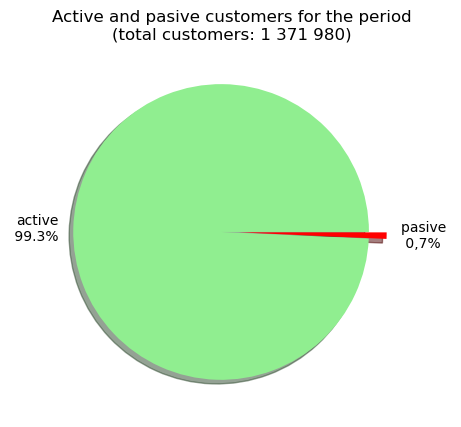

In [8]:
# Plot of active vs. pasive customenrs 
plt.pie( [1362281, 9699], labels=[ 'active\n 99.3%', 'pasive \n 0,7%'], colors=['lightgreen','red'],explode= [.07, .05], shadow= True)
plt.title('Active and pasive customers for the period\n(total customers: 1 371 980)')
plt.show()

The count of **total customers** is 1371980.

The count of *active customers* (who purcaised during the period) is 1362281.

The difference are *pasive customers* (who didn't purcaise during the period): 9699.

### 1.2. Segmentation in Groups

I define 2 basic types of customers depending on their way of purchase:
 - 1.0 -> on site (in a shop)
 - 2.0 -> on line (via internet)

In [9]:
group = df.groupby('customer_id').sales_channel_id.mean().round().reset_index()

In [10]:
# Cast 'customer_id' from object to int
group.customer_id = group.customer_id.apply(lambda s: int(s[-16:], 16)) 

In [11]:
# Marging with cid
group = group.merge(cid, on='customer_id', how='right')# .rename(columns={'sales_channel_id':'group'})

group

,customer_id,sales_channel_id
0,6883939031699146327,2.0
1,11246327431398957306,2.0
2,18439897732908966680,2.0
3,18352672461570950206,2.0
4,18162778555210377306,2.0
...,...,...
1371975,7551062398649767985,2.0
1371976,9305341941720086711,2.0
1371977,10160427316885688932,2.0
1371978,2551401172826382186,2.0


In "group" we have now empty cells because some customers were _inactive_ during the period (didn't make any purchase).

We check how many they are and dicide to add  _inactive customers_ to type 1.0 -> buying mainly "in a shop":

In [12]:
group.sales_channel_id.value_counts(dropna= False)

2.0    928128
1.0    434153
NaN      9699
Name: sales_channel_id, dtype: int64

In [13]:
group.sales_channel_id.value_counts(dropna= False)[np.nan]
type(group.sales_channel_id.value_counts(dropna= False)[np.nan])

numpy.int64

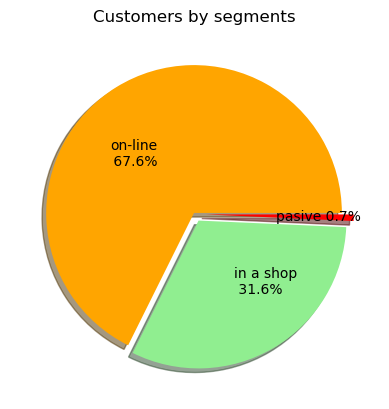

In [14]:
# Plot of customenrs by distribution channels
# Share in % (percentage) per segment:
perc_on_line = round(group.sales_channel_id.value_counts(normalize= True, dropna= False)[2] * 100, 1)
perc_in_shop =round(group.sales_channel_id.value_counts(normalize= True, dropna= False)[1]* 100, 1)
perc_pasive = round(group.sales_channel_id.value_counts(normalize= True, dropna= False)[np.nan]* 100, 1)
plt.pie( 
        [group.sales_channel_id.value_counts(dropna= False)[2],
         group.sales_channel_id.value_counts(dropna= False)[1], 
         group.sales_channel_id.value_counts(dropna= False)[np.nan]], 
        labels=[ f'on-line\n {perc_on_line}%', f'in a shop\n {perc_in_shop}%', f'pasive {perc_pasive}%'], 
        colors=['orange', 'lightgreen', 'red'],
        explode= [0.01, .05, .075], 
        shadow= True,
        labeldistance= .475
        )
plt.title('Customers by segments')

plt.show()

The *pasive customers* number isn't significant and we decide to unite it with "in-a-shop" customers.

In [15]:
grouping = group.sales_channel_id.fillna(1.0)

In [16]:
grouping.value_counts()

2.0    928128
1.0    443852
Name: sales_channel_id, dtype: int64

### 1.3. Check and fitting "df" with proper data 

In [17]:
df['t_dat'] = pd.to_datetime(df['t_dat'])

In [18]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                   int64
price                      float64
sales_channel_id             int64
dtype: object

In [19]:
# Insert a column to refer the weeks
df['week'] = df['t_dat'].dt.isocalendar().week

In [20]:
# Convert 'customer_id' from str as int 

df['customer_id'] = df['customer_id'].apply(lambda s: int(s[-16:], 16))

In [21]:
# Initializing a new column
df['week_count'] = 0

# Counting weeks from zero.
start_date = df['t_dat'].iloc[0]
df['week_count'] = ((df['t_dat'] - start_date).dt.days // 7).astype(int)


In [22]:
df

,t_dat,customer_id,article_id,price,sales_channel_id,week,week_count
0,2018-09-20,18439897732908966680,663713001,0.050831,2,38,0
1,2018-09-20,18439897732908966680,541518023,0.030492,2,38,0
2,2018-09-20,10112112306570742978,505221004,0.015237,2,38,0
3,2018-09-20,10112112306570742978,685687003,0.016932,2,38,0
4,2018-09-20,10112112306570742978,685687004,0.016932,2,38,0
...,...,...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,929511001,0.059305,2,39,104
31788320,2020-09-22,4685485978980270934,891322004,0.042356,2,39,104
31788321,2020-09-22,3959348689921271969,918325001,0.043203,1,39,104
31788322,2020-09-22,9807404028332039951,833459002,0.006763,1,39,104


In [23]:
# We aim to count the weeks only during the period.
# So we drop the 'week'feature avoidig some duality.

df = df.drop(columns=['week'])

Finaly it seems everething to look nice. :)

## 2.Modeling
### 2.1 with One-Week retention (4-11 days)

Some preparations first:

In [24]:
def iter_to_str(iterable):
    ''' The function collects all elements of input, 
    then it joins with white space and puts a zero at the begin of each of them.
     
    Input  : iterable object
    Return : str (in pd.Series) 
    '''
    return " ".join(map(lambda x: str(0) + str(x), iterable))

In [25]:
val_week = 104
# id of week to be used in a validation; 
# remeber to set 'val_week' 104 if create a submission for 'kaggle'

val = df.loc[df.week_count == val_week].groupby('customer_id', group_keys=True).article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right')

In [26]:
val.article_id.nunique()

48150

In [27]:
# Check the actual 'article_id'-s
actual = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())

In [28]:
type(actual), actual.shape

(pandas.core.series.Series, (1371980,))

In [29]:
last_date = df.loc[df.week_count < val_week].t_dat.max()

In [30]:
last_date 

Timestamp('2020-09-16 00:00:00')

### 2.2. Common functions

In [31]:
def apk(actual, predicted, k=12):
    '''It calculates the Average Precision at k for a given list of actual and predicted values 
    upon fulfillment of conditions.
    Input : 
        - 'actual' list of actual values, where each element corresponds to an actual value that is available.  
        - 'predicted' list of predicted values, where each element corresponds to a predicted value.
        - 'k' int that specifies the maximum number of results to consider when calculating the accuracy.
    Return:
        - the average accuracy, which is obtained as the sum of the accuracies of all correctly predicted items 
        divided by the minimum between the count of 'actual'-s and 'k'.  
    '''
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    '''The function is used to calculate the average precision of predictions for a set of data. 
       It uses the subfunction 'apk' (average precision at k) to calculate the precision for each element of the list.
    Input : 
        - 'actual'  list
        - 'predicted' list (assuming that the two lists have the same number of elements).
    Return:
        - the average precision for all elements.
        - If return_apks is True, the function returns a list of precisions for each element. 
                If False, returns the average precision for all elements.
    '''
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def validation(actual, predicted, grouping, score=0, index=-1, ignore=False, figsize=(12, 6)):
    '''This function is used to evaluate a model's predictions on specific groups of data (eg, product categories, regions, etc.) 
        By calculating the arithmetic mean of the Average Precision at 'k' (MAP@k) metric for each group and for all data. 
        At the end the function displays a histogram of the MAP@k values, calculates and stores the MAP@k values ​​for each group and for all data in the DataFrame "score".
        Input :
            - 'actual', 'predicted' : list of list 
            - 'grouping' of the data "grouping"
            -  'score'  : DataFrame  to store the scores and some other parameters.  
        Return:
            - 'score' DataFrame.
    '''
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    if ignore: 
        return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if isinstance(score, int): 
        score = pd.DataFrame({g:[] for g in sorted(grouping.unique().tolist())})
    if index == -1 : 
        index = score.shape[0]
    score.loc[index, "All"] = map12
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1); 
    sns.histplot(data=ap12, log_scale=(0, 10), bins=20, color= 'orange'); 
    plt.title(f"MAP@12 : {map12}")
    for g in grouping.unique():
        map12 = round(mapk(actual[grouping == g], predicted[grouping == g]), 6)
        score.loc[index, g] = map12
    plt.subplot(122) 
    score[[g for g in grouping.unique()[::-1]] + ['All']].loc[index].plot.barh(); 
    plt.title(f"MAP@12 of Groups")
    vc = pd.Series(predicted).apply(len).value_counts()
    score.loc[index, "Fill"] = round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
    display(score)
    return score

### 2.3. Last Purchased Items

,1.0,2.0,All,Fill
Last Purchase,0.013407,0.025365,0.021444,28.7


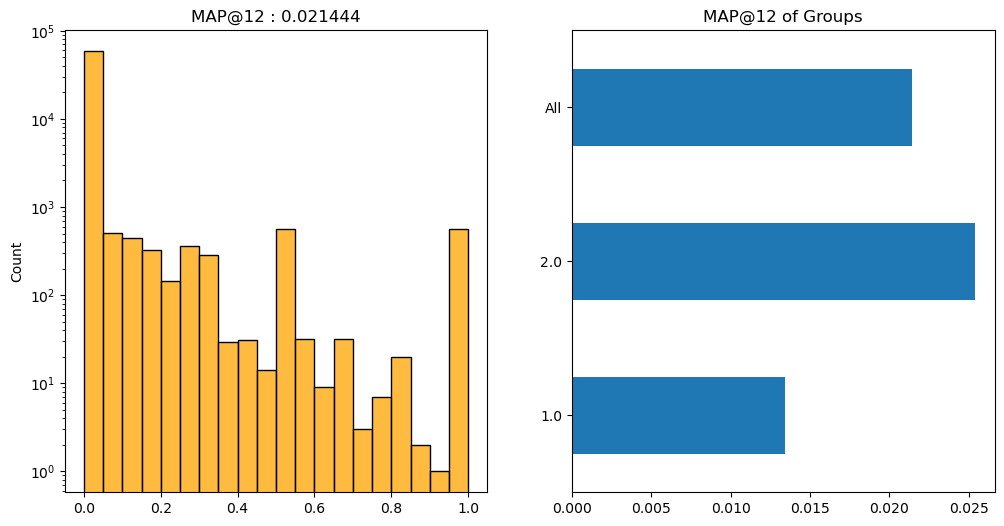

In [32]:
init_date = last_date - dt.timedelta(days=9999)
# filter data for the priod  
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()
# inserting of new columns:
# ['l_dat'] -> last date of customers purchase. 
# ['d_dat'] -> days between last purchase of customer and last_date.
train = train.merge(train.groupby('customer_id').t_dat.max().reset_index().rename(columns={'t_dat':'l_dat'}),
                   on = 'customer_id', how='left')

train['d_dat'] = (train.l_dat - train.t_dat).dt.days

# filter so that gets only rows where 'd_dat'< 14 and sorting according to 't_dat' 
# collecting only rows with unique values (drop_duplicates) in columns['customer_id', 'article_id'].
train = train.loc[train.d_dat < 14].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])

# sub['last_purchase'] save last purchase(s) of each customer as string, using 'iter_to_str'
sub['last_purchase'] = train.groupby('customer_id')\
    .article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right').article_id.fillna('')

# In new DataFrame 'predicted' are saved all values from column sub['last_purchase'] before that they are splited.
predicted = sub['last_purchase'].apply(lambda s: [] if pd.isna(s) else s.split())

# 'score' saves results of 'validation' function.
# It compares model-predicted and actual purchases for each customer and returns the average accuracy (MAP@12) of the model.
score = validation(actual, predicted, grouping, index='Last Purchase', ignore=(val_week == 105))

### 2.4.Other Colors of Purchased Item

,1.0,2.0,All,Fill
Last Purchase,0.013407,0.025365,0.021444,28.7
Other Colors,0.005823,0.008405,0.007558,15.3


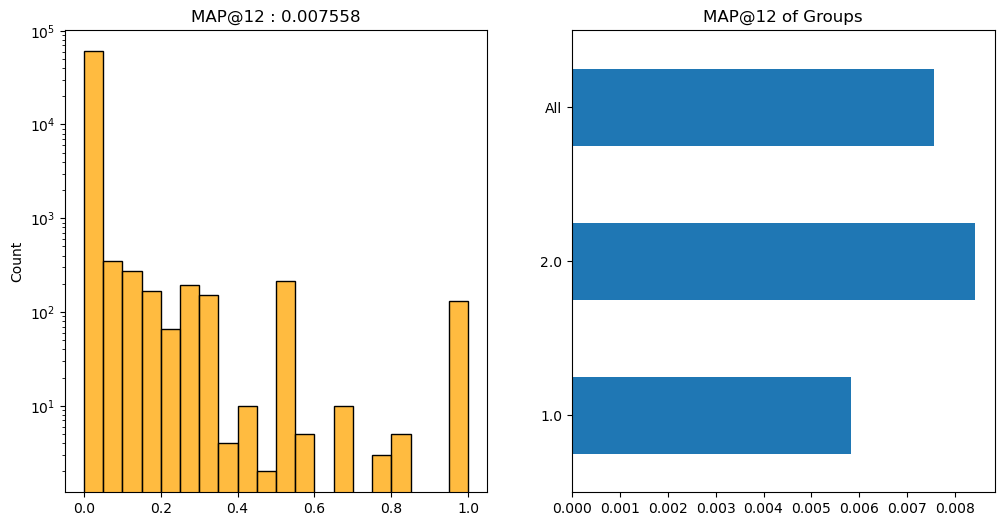

In [33]:
init_date = last_date - dt.timedelta(days=6)
train_1 = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .groupby(['article_id']).t_dat.count().reset_index()
adf = pd.read_csv(r'data\articles.csv\articles.csv')
adf = adf.merge(train_1, on='article_id', how='left').rename(columns={'t_dat':'ct'})\
    .sort_values('ct', ascending=False).query('ct > 0')

map_to_col = defaultdict(list)
for aid in adf.article_id.tolist():
    map_to_col[aid] = list(filter(lambda x: x != aid, adf[adf.product_code == aid // 1000].article_id.tolist()))[:1]

def map_to_variation(s):
    f = lambda item: iter_to_str(map_to_col[int(item)])
    return ' '.join(map(f, s.split()))
sub['other_colors'] = sub['last_purchase'].fillna('').apply(map_to_variation)

predicted = sub['other_colors'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Other Colors', ignore=(val_week == 105))

# before
#	            1.0	           2.0	    All	        Fill
# Last Purchase	0.901186	0.847087	0.865238	28.7
# Other Colors	0.023821	0.038847	0.033806	15.0


### 2.5.Popular Items for Each Group

,1.0,2.0,All,Fill
Last Purchase,0.013407,0.025365,0.021444,28.7
Other Colors,0.005823,0.008405,0.007558,15.3
Popular Items,0.008888,0.008480,0.008613,99.3


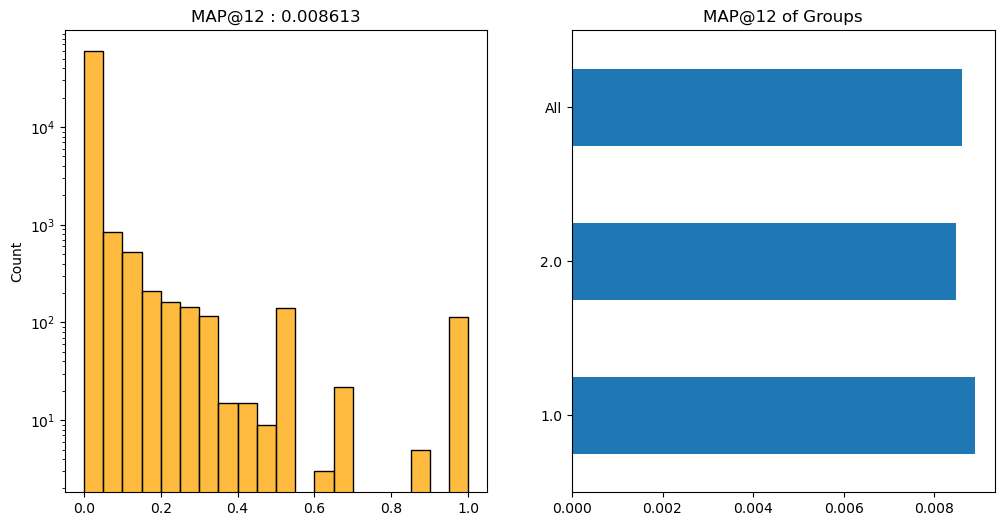

In [34]:
# 4 days are half week and more precise for this purpose
init_date = last_date - dt.timedelta(days=4)
# grouping can be changed
group_df = pd.concat([cid, group.sales_channel_id], axis=1) 
group_df.columns = ['customer_id', 'group']
train_2 = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['group', 'article_id']).t_dat.count().reset_index()
items = defaultdict(str)
for g in train_2.group.unique():
    items[g] = iter_to_str(train_2.loc[train_2.group == g].sort_values('t_dat', ascending=False).article_id.tolist()[:12])

sub['popular_items'] = group_df.group.map(items)

predicted = sub['popular_items'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Popular Items', ignore=(val_week == 105))

## 3. Final prediction

Now we do _**mixed Predictions**_ **(Blending)** in order to achive better results on the desired dataset.

Here we'll use previouse results saved in *sub['last_purchase', 'other_colors', 'popular_items']*.

In [35]:
def blend(dt, w=[], k=12):
    ''' it performs blending of the strings in 'dt' list, giving greater weight to that appears earlier in the list. 
        This is done by multiplying each prediction (element of dt) by the corresponding weight from the list 'w'.
        Aftre that the strings are sorted in descending order of their weight (higher weight means earlier occurrence in the list).
    Input  :
        - 'dt' : list of strings|Any
        - 'w'  : empty list
        - 'k'  : int
    Return:    
        - the first 'k' strings are returned as one common text string.
    '''
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    '''it  "trims" the predicted elements that are not in the 'ok_set' and are in 'post'
       it returns a new string that contains the first 'k' elements that are in the 'ok_set'
    Input : 
        - 'pred'  : string|Any
        - 'ok_set': set|Any
        - 'k'     :  int
    Return:
        - string of the firts 'k' elements
    '''
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

In [36]:
init_date = last_date - dt.timedelta(days=11)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

,1.0,2.0,All,Fill
Last Purchase,0.013407,0.025365,0.021444,28.7
Other Colors,0.005823,0.008405,0.007558,15.3
Popular Items,0.008888,0.008480,0.008613,99.3
Prediction,0.018691,0.030582,0.026683,99.3


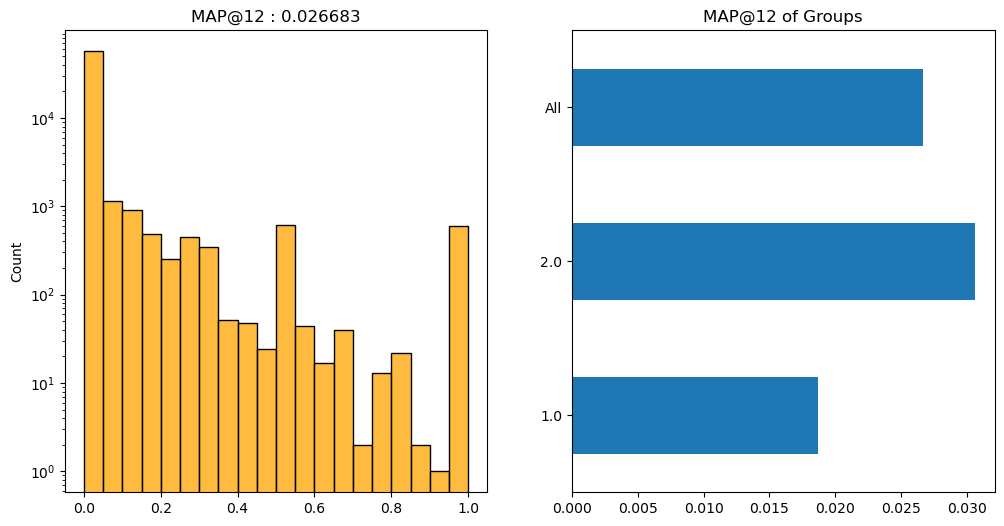

In [37]:
sub['prediction'] = sub[['last_purchase', 'other_colors', 'popular_items']]\
    .apply(blend, w=[100, 10, 1], axis=1, k=32).apply(prune, ok_set=sold_set)
predicted = sub.prediction.apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Prediction', ignore=(val_week == 105))

# results before with w = [100, 10]
# 	            1.0	        2.0	        All	        Fill
# Last Purchase	0.013407	0.025365	0.021444	28.7
# Other Colors	0.005823	0.008405	0.007558	15.3
# Popular Items	0.008888	0.008480	0.008613	99.3
# Prediction	0.015179	0.027625	0.023544	30.6

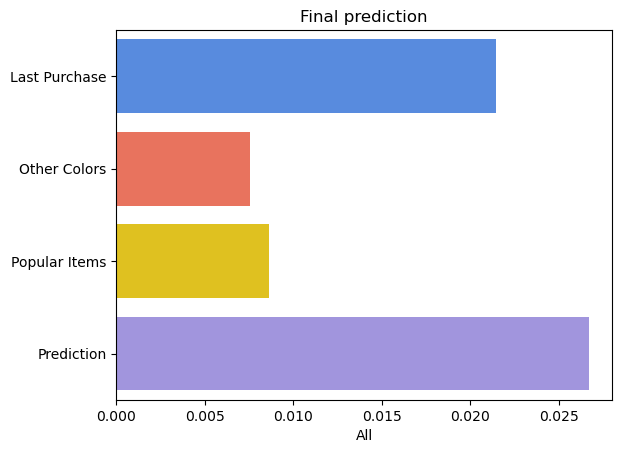

In [38]:
sns.barplot(data=score, x='All', y=score.index, palette=['#4286f4', '#ff6347', '#ffd700', '#9989e9'])
plt.title("Final prediction")
plt.show()

In [39]:
# if val_week == 105: sub[['customer_id', 'prediction']].to_csv('submission.csv', index=False)

## 4. Conclusion

The final results show that to do prediction on customers who are buying direct on-place is difficult.

Avarage precision per diffrent groups is:

+ 0.0187 for on-line sales 
+ 0.0306 for on-place sales



There is a vast deversity how to make prediction about a future behavior of customers.

Here I've choosen a simple aproach demonstaring only one possibility.

According to my oppinion the results are quite good and for sure there are better ways to solve the task.

Because it's a private task with special purpose I didn't make yet any submission to Kaggle competition.


## 5. References

The order of the sources is alphabetical.

- https://chat.openai.com/
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html#matplotlib.pyplot.barh
- https://seaborn.pydata.org/
- https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview


Thank you for your attention!

:)